In [1]:
import pickle
from pytorch_lightning import LightningModule, Trainer, seed_everything
from pytorch_lightning.loggers import TensorBoardLogger
from torch import nn
import torch
from argparse import ArgumentParser
import pytorch_lightning as pl
from torch.nn import functional as F
import random
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from transformers import logging
import os
from matplotlib import pyplot
logging.set_verbosity_error()

c:\Users\ID\.conda\envs\py310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
with open('text_dataset.pickle', 'rb') as f:
    text_dataset = pickle.load(f)

In [3]:
text_dataset = text_dataset[:, 0, :]

In [4]:
batch_size = 8

In [5]:
def create_dataset(path_to_data, batch_size=100, crop_size=224, num_of_channels=1):
    transform = transforms.Compose(
        [
            #transforms.RandomRotation(degrees=(0, 360)),
            transforms.Resize(crop_size),
            transforms.CenterCrop(crop_size),
            transforms.ToTensor(),
            transforms.Grayscale(num_output_channels=num_of_channels),
        ]
    )
    dataset = ImageFolder(root=path_to_data, transform=transform)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=False,
        drop_last=False,
        pin_memory=True,
        num_workers=8,
    )
    return dataset, dataloader

In [6]:
class View(nn.Module):
    def __init__(self, shape):
        super(View, self).__init__()
        self.shape = shape

    def forward(self, x):
        return x.view(*self.shape)

In [7]:
class VAE(LightningModule):

    def __init__(
        self,
        input_height: int,
        enc_type: str = "default",
        first_conv: bool = False,
        maxpool1: bool = False,
        enc_out_dim: int = 5488,
        kl_coeff: float = 0.01,
        latent_dim: int = 5488,
        lr: float = 1e-3,
        **kwargs,
    ):
        super().__init__()

        self.save_hyperparameters()
        self.lr = lr
        self.kl_coeff = kl_coeff
        self.enc_out_dim = enc_out_dim
        self.latent_dim = latent_dim
        self.input_height = input_height

        if enc_type == "default":
            if input_height == 224:
                self.encoder = nn.Sequential(
                    nn.Conv2d(1, 224, (3,3), stride=(1,1), padding=(1,1)),  # 224 x 224 x 224
                    nn.ReLU(True),
                    nn.MaxPool2d(2),  # 224 x 112 x 112
        
                    nn.Conv2d(224, 112, (3,3), stride=(1,1), padding=(1,1)),  # 112 x 112 x 112
                    nn.ReLU(True),
                    nn.MaxPool2d(2),  # 112 x 56 x 56
        
                    nn.Conv2d(112, 56, (3,3), stride=(1,1), padding=(1,1)),  # 56 x 56 x 56
                    nn.ReLU(True),
                    nn.MaxPool2d(2),  # 56 x 28 x 28
        
                    nn.Conv2d(56, 7, (3, 3), stride=(1,1), padding=(1,1)),  # 7 x 28 x 28
                    nn.Flatten()  # 5488 x 1 x 1
                )
                 
                self.decoder = nn.Sequential(    
                    View([-1, 7, 28, 28]),
                    nn.ConvTranspose2d(7, 56, (3, 3), stride=(1,1), padding=(1,1)),  # 32 x 32 x 32
                    nn.ReLU(True),
                    nn.Upsample(scale_factor=2),  # 32 x 64 x 64
                
                    nn.ConvTranspose2d(56, 112, (3,3), stride=(1,1), padding=(1,1)),  # 64 x 64 x 64
                    nn.ReLU(True),
                    nn.Upsample(scale_factor=2),  # 64 x 128 x 128
        
                    nn.ConvTranspose2d(112, 224, (3,3), stride=(1,1), padding=(1,1)),  # 128 x 128 x 128
                    nn.ReLU(True),
                    nn.Upsample(scale_factor=2),  # 64 x 128 x 128
        
                    nn.ConvTranspose2d(224, 1, (3,3), stride=(1,1), padding=(1,1)),
                    nn.Sigmoid()
                )
        self.fc_mu = nn.Linear(self.enc_out_dim, self.latent_dim)
        self.fc_var = nn.Linear(self.enc_out_dim, self.latent_dim)

    @staticmethod
    def pretrained_weights_available():
        return list(VAE.pretrained_urls.keys())

    def from_pretrained(self, checkpoint_name):
        if checkpoint_name not in VAE.pretrained_urls:
            raise KeyError(str(checkpoint_name) + " not present in pretrained weights.")

        return self.load_from_checkpoint(VAE.pretrained_urls[checkpoint_name], strict=False)

    def forward(self, x):
        x = self.encoder(x)
        mu = self.fc_mu(x)
        log_var = self.fc_var(x)
        p, q, z = self.sample(mu, log_var)
        return self.decoder(z)

    def _run_step(self, x):
        x = self.encoder(x)
        mu = self.fc_mu(x)
        log_var = self.fc_var(x)
        p, q, z = self.sample(mu, log_var)
        return z, self.decoder(z), p, q
    def sample(self, mu, log_var):
        std = torch.exp(log_var / 2)
        p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
        q = torch.distributions.Normal(mu, std)
        z = q.rsample()
        return p, q, z

    def step(self, batch, batch_idx):
        x, y = batch
        z, x_hat, p, q = self._run_step(x)
        ls = nn.BCELoss()
        recon_loss = ls(x_hat, x)
        kl = torch.distributions.kl_divergence(q, p)
        kl = kl.mean()
        kl *= self.kl_coeff

        loss = recon_loss + kl 

        logs = {
            "recon_loss": recon_loss,
            "kl": kl,
            "loss": loss,
        }
        return loss, logs

    def training_step(self, batch, batch_idx):
        loss, logs = self.step(batch, batch_idx)
        self.log_dict({f"train_{k}": v for k, v in logs.items()}, on_step=True, on_epoch=False)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, logs = self.step(batch, batch_idx)
        self.log_dict({f"val_{k}": v for k, v in logs.items()})
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

In [8]:
def Create_image_embeddings(path_to_data, ckpt_path, batch_size = 100, crop_size = 224, num_of_channels = 1):
    model = VAE.load_from_checkpoint(ckpt_path)
    model.eval()
    dataset, dataloader = create_dataset(
        path_to_data, batch_size, crop_size, num_of_channels
    )
    all_z = torch.tensor([]).cuda()
    for img in dataset:
        input_img = img[0].to(model.device)
        with torch.no_grad():
            model.eval()
            z = model.encoder(input_img).flatten()
            model.train()
        all_z = torch.cat((all_z, z.cuda().unsqueeze(0)), 0)
        print(all_z.shape[0], "images preprocessed out of", len(dataset))
    return all_z

In [9]:
image_files = [file for file in os.listdir('images\img') if file.endswith(".png")]

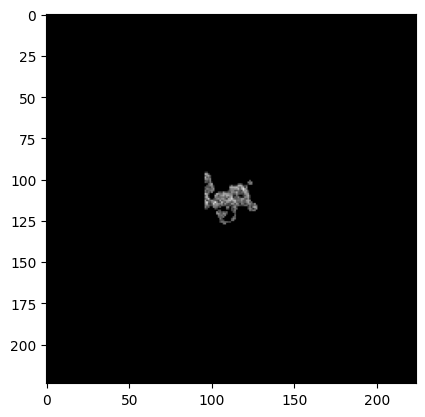

In [10]:
dataset, dataloader = create_dataset(
    'images/', 8, 224, 1
)

import matplotlib.pyplot as plt
plt.imshow(dataset[4][0].permute(1, 2, 0))
from PIL import Image
im = Image.open('images/img/' + image_files[4])
plt.imshow(im)
plt.show()

In [29]:
image_dataset = Create_image_embeddings(
    'images/',
    'vae.ckpt',
)

1 images preprocessed out of 1500
2 images preprocessed out of 1500
3 images preprocessed out of 1500
4 images preprocessed out of 1500
5 images preprocessed out of 1500
6 images preprocessed out of 1500
7 images preprocessed out of 1500
8 images preprocessed out of 1500
9 images preprocessed out of 1500
10 images preprocessed out of 1500
11 images preprocessed out of 1500
12 images preprocessed out of 1500
13 images preprocessed out of 1500
14 images preprocessed out of 1500
15 images preprocessed out of 1500
16 images preprocessed out of 1500
17 images preprocessed out of 1500
18 images preprocessed out of 1500
19 images preprocessed out of 1500
20 images preprocessed out of 1500
21 images preprocessed out of 1500
22 images preprocessed out of 1500
23 images preprocessed out of 1500
24 images preprocessed out of 1500
25 images preprocessed out of 1500
26 images preprocessed out of 1500
27 images preprocessed out of 1500
28 images preprocessed out of 1500
29 images preprocessed out of

In [12]:
train_dl = DataLoader([[text_dataset[int(image_name.split(sep='_')[1])], image_dataset[i]] for i, image_name in enumerate(image_files)], shuffle=True, batch_size=batch_size, num_workers=4)

In [13]:
class AE(LightningModule):

    def __init__(
        self,
        lr: float = 1e-5,
        kl_coeff: float = 0.1,
        latent_dim: int = 768,
        enc_out_dim: int = 768,
        **kwargs,
    ):
        super().__init__()

        self.save_hyperparameters()
        self.kl_coeff = kl_coeff
        self.lr = lr
        self.enc_out_dim = enc_out_dim
        self.latent_dim = latent_dim
        self.encoder = nn.Sequential(
            nn.Linear(768, 768),
            nn.ReLU(True),
            nn.Linear(768, 768),
        )

        self.decoder = nn.Sequential(          
            nn.Linear(768, 2048),
            nn.ReLU(True),
            nn.Linear(2048, 5488),
        )
        self.fc_mu = nn.Linear(self.enc_out_dim, self.latent_dim)
        self.fc_var = nn.Linear(self.enc_out_dim, self.latent_dim)

    def forward(self, x):
        x = self.encoder(x)
        mu = self.fc_mu(x)
        log_var = self.fc_var(x)
        p, q, z = self.sample(mu, log_var)
        return self.decoder(z)

    def _run_step(self, x):
        x = self.encoder(x)
        mu = self.fc_mu(x)
        log_var = self.fc_var(x)
        p, q, z = self.sample(mu, log_var)
        return z, self.decoder(z), p, q

    def sample(self, mu, log_var):
        std = torch.exp(log_var / 2)
        p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
        q = torch.distributions.Normal(mu, std)
        z = q.rsample()
        return p, q, z
    
    def step(self, batch, batch_idx):
        x, y = batch
        z, x_hat, p, q = self._run_step(x)
        recon_loss = F.mse_loss(x_hat, y)
        kl = torch.distributions.kl_divergence(q, p)
        kl = kl.mean()
        kl *= self.kl_coeff

        loss = recon_loss + kl 

        logs = {
            "recon_loss": recon_loss,
            "kl": kl,
            "loss": loss,
        }
        return loss, logs

    def training_step(self, batch, batch_idx):
        loss, logs = self.step(batch, batch_idx)
        self.log_dict({f"train_{k}": v for k, v in logs.items()}, on_step=True, on_epoch=False)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, logs = self.step(batch, batch_idx)
        self.log_dict({f"val_{k}": v for k, v in logs.items()})
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

In [14]:
ae = AE()
logger = TensorBoardLogger("Results_Linker", name='Results_Linker')
trainer = pl.Trainer(
    max_epochs=200,
    log_every_n_steps=100,
    logger = logger
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [22]:
trainer.fit(ae, train_dl)

You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
c:\Users\ID\.conda\envs\py310\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:615: UserWarning: Checkpoint directory Results_Linker\Results_Linker\version_1\checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 1.2 M 
1 | decoder | Sequential | 12.8 M
2 | fc_mu   | Linear     | 590 K 
3 | fc_var  | Linear     | 590 K 
---------------------------------------
15.2 M    Trainable params
0         Non-trainable par

Epoch 13:  59%|█████▊    | 110/188 [00:10<00:07, 10.49it/s, v_num=1]

In [36]:
number_of_samples = 1

In [37]:
save_to = "Result_Connector\\{r}\\".format(r = 'Results_Linker') + "epoch_{e}\\".format(e = trainer.current_epoch) + "version_{v}\\".format(v = 0)

randomlist = random.sample(range(0, len(text_dataset)), number_of_samples)
x = text_dataset[randomlist].clone().detach()
y = image_dataset[randomlist].clone().detach()
with torch.no_grad():
    ae.eval()
    y_reconst = ae(x.to(ae.device))
    ae.train()

transform = transforms.Compose(
    [
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Grayscale(num_output_channels=1),
    ]
)
initial = [dataset[i][0] for i in randomlist]

In [38]:
def Reconstruct(embedding, ckpt_path):
    model = VAE.load_from_checkpoint(ckpt_path)
    model.eval().cuda()
    mu = model.fc_mu(embedding.cuda())
    log_var = model.fc_var(embedding.cuda())
    p, q, z = model.sample(mu, log_var)
    decoded = model.decoder(z)
    return decoded

In [39]:
def Plot_results(reconstruct, real, initial, save_to, ckpt_path):
    for i in range(len(real)):
        pyplot.figure(figsize=(20,12))
        pyplot.subplot(131)
        pyplot.imshow(initial[i][0], cmap="gray")
        pyplot.title("Initial")
        pyplot.subplot(132)
        pyplot.imshow(Reconstruct(real, ckpt_path)[i].cpu().detach().numpy()[0], cmap="gray")
        pyplot.title("Reconstructed")
        pyplot.subplot(133)
        pyplot.imshow(Reconstruct(reconstruct, ckpt_path)[i].cpu().detach().numpy()[0], cmap="gray")
        pyplot.title("Generated")
        if save_to is not None:
            if not os.path.exists(save_to + "recs/"):
                os.makedirs(save_to + "recs/")
            pyplot.savefig(save_to + "recs/{}.pdf".format(i))
        else:
            pyplot.show()
    pyplot.close("all")

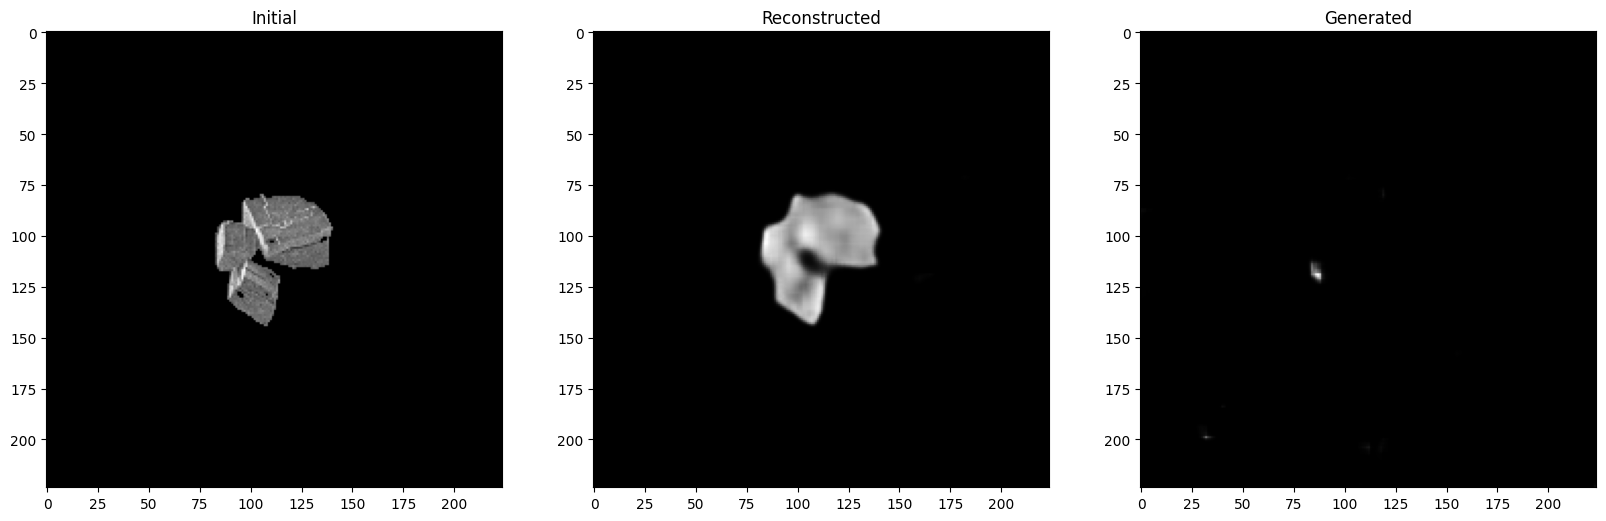

In [40]:
Plot_results(y_reconst, y, initial, None, 'vae.ckpt')

In [41]:
#Plot_results(y_reconst, y, initial, save_to, 'vae.ckpt')